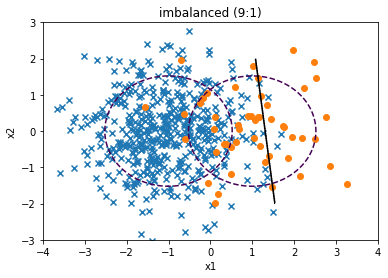

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.svm import SVC

def classification_result(n0, n1, title=""):
    rv1 = sp.stats.multivariate_normal([-1, 0], [[1, 0], [0, 1]])
    rv2 = sp.stats.multivariate_normal([+1, 0], [[1, 0], [0, 1]])
    X0 = rv1.rvs(n0, random_state=0)
    X1 = rv2.rvs(n1, random_state=0)
    X = np.vstack([X0, X1])
    y = np.hstack([np.zeros(n0), np.ones(n1)])

    x1min = -4; x1max = 4
    x2min = -2; x2max = 2
    xx1 = np.linspace(x1min, x1max, 1000)
    xx2 = np.linspace(x2min, x2max, 1000)
    X1, X2 = np.meshgrid(xx1, xx2)

    plt.contour(X1, X2, rv1.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")
    plt.contour(X1, X2, rv2.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")

    model = SVC(kernel="linear", C=1e4, random_state=0).fit(X, y)
    Y = np.reshape(model.predict(np.array([X1.ravel(), X2.ravel()]).T), X1.shape)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='x', label="0 클래스")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='o', label="1 클래스")
    plt.contour(X1, X2, Y, colors='k', levels=[0.5])
    y_pred = model.predict(X)
    plt.xlim(-4, 4)
    plt.ylim(-3, 3)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    
    return model, X, y, y_pred

model, X, y, y_pred = classification_result(500, 50, "imbalanced (9:1)")

# Naive Bayes Classifier, cost-sensitive learning

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, stratify=y)

train_data = pd.DataFrame(np.concatenate([X_train,y_train.reshape(-1,1)],axis=1), columns= ['x1', 'x2', 'y'])
test_data = pd.DataFrame(np.concatenate([X_test, y_test.reshape(-1,1)], axis=1), columns = ['x1', 'x2', 'y'])

train_data_0 = train_data[train_data['y']==0]
train_data_1 = train_data[train_data['y']==1]
p = {0:len(train_data_0)/len(train_data), 1:len(train_data_1)/len(train_data)}
# test_data_1 = test_data[test_data['y']==0]
# test_data_1 = test_data[test_data['y']==1]

In [59]:
mean_neg_0 = train_data_0['x1'].mean()
mean_neg_1 = train_data_0['x2'].mean()
var_neg_0 = train_data_0['x1'].var()
var_neg_1 = train_data_0['x2'].var()

mean_pos_0 = train_data_1['x1'].mean()
mean_pos_1 = train_data_1['x2'].mean()
var_pos_0 = train_data_1['x1'].var()
var_pos_1 = train_data_1['x2'].var()

neg_x1 = sp.stats.norm(mean_neg_0, var_neg_0)
neg_x2 = sp.stats.norm(mean_neg_1, var_neg_1)

pos_x1 = sp.stats.norm(mean_pos_0, var_pos_0)
pos_x2 = sp.stats.norm(mean_pos_1, var_pos_1)

> Cost를 고려하지 않은 모델

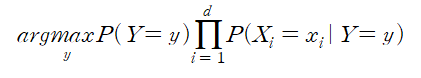

In [153]:
def NaiveBayesclf(X):
    arr = []
    for i in range(len(X)):
        if (p[0]*neg_x1.pdf(X[i][0])*neg_x2.pdf(X[i][1])) > (p[1]*pos_x1.pdf(X[i][0])*pos_x2.pdf(X[i][1])):
            arr.append(0)
        else:
            arr.append(1)
    
    return np.array(arr)
    
y_pred = NaiveBayesclf(X_test)
confusion_matrix(y_test,y_pred)

array([[147,   3],
       [  9,   6]], dtype=int64)

>Cost를 고려한 모델(Expected Cost Minimization)

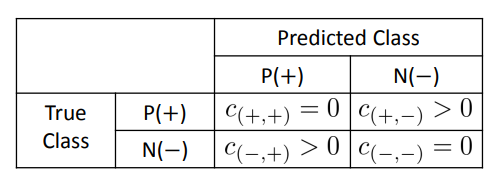

In [70]:
cost =[[0,8],[3,0]] # positive(minority) class에 대한 오분류 비용 C_(+,-)가 더 cost가 큼

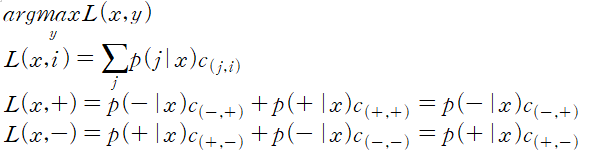

In [151]:
def CostNaiveBayesclf(X):
    arr = []
    for i in range(len(X)):
        if (cost[1][0]*p[0]*neg_x1.pdf(X[i][0])*neg_x2.pdf(X[i][1])) > (cost[0][1]*p[1]*pos_x1.pdf(X[i][0])*pos_x2.pdf(X[i][1])): # c_(j,i)
            arr.append(0)
        else:
            arr.append(1)
    
    return np.array(arr)
    
y_pred = CostNaiveBayesclf(X_test)
confusion_matrix(y_test,y_pred)

array([[142,   8],
       [  5,  10]], dtype=int64)

# Latent Discriminant Analysis, cost-sensitive learning

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)

train_data = pd.DataFrame(np.concatenate([X_train,y_train.reshape(-1,1)],axis=1), columns= ['x1', 'x2', 'y'])
test_data = pd.DataFrame(np.concatenate([X_test, y_test.reshape(-1,1)], axis=1), columns = ['x1', 'x2', 'y'])

train_data_0 = train_data[train_data['y']==0]
train_data_1 = train_data[train_data['y']==1]

mu_0 = np.array([train_data_0['x1'].mean(), train_data_0['x2'].mean()])
mu_1 = np.array([train_data_1['x1'].mean(), train_data_1['x2'].mean()])

mean_centered_train_0 = train_data_0[['x1', 'x2']] - mu_0.reshape(-1,2)
mean_centered_train_1 = train_data_1[['x1', 'x2']] - mu_1.reshape(-1,2)

sigma_0 = (mean_centered_train_0.T @ mean_centered_train_0)/(len(mean_centered_train_0)-1)
sigma_1 = (mean_centered_train_1.T @ mean_centered_train_1)/(len(mean_centered_train_1)-1)

n1 = len(train_data_0)
n2 = len(train_data_1)
sigma = (n1*sigma_0 + n2*sigma_1)/(n1+n2)

In [124]:
f_0 = sp.stats.multivariate_normal(mu_0, sigma) # negative
f_1 = sp.stats.multivariate_normal(mu_1, sigma) # positive

In [126]:
cost =[[0,8],[3,0]] # C_(+,-)가 더 cost가 큼

In [ ]:
def LDA(X):
    arr = []
    for i in range(len(X)):
        #if(mu_1 - mu_0).T@np.linalg.inv(sigma)@X[i] >= (mu_1 - mu_0).T@np.linalg.inv(sigma)@(mu_1+mu_0):
        if f_1.pdf(X[i])>=f_0.pdf(X[i]):
            arr.append(1)
        else:
            arr.append(0)
    return np.array(arr)

y_pred = LDA(X_test)

confusion_matrix(y_test, y_pred)

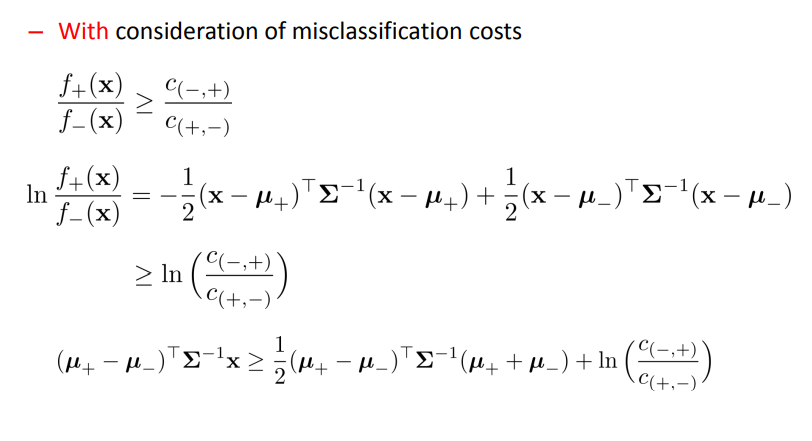

In [155]:
def CostLDA(X):
    arr = []
    for i in range(len(X)):
        if(mu_1 - mu_0).T@np.linalg.inv(sigma)@X[i] >= (mu_1 - mu_0).T@np.linalg.inv(sigma)@(mu_1+mu_0)+np.log(cost[1][0]/cost[0][1]):
            arr.append(1)
        else:
            arr.append(0)
    return np.array(arr)

y_pred = CostLDA(X_test)

confusion_matrix(y_test, y_pred)

array([[116,  34],
       [  0,  15]], dtype=int64)